# ANOVA with age and sex of donor in batches of MATseq


02-04-2023

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats
from scipy.stats import f_oneway

In [27]:
# Set the displya size of pd DataFrames
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 200)
pd.set_option("display.precision", 5)
pd.set_option("display.max_seq_items", 50)
pd.set_option("display.max_seq_items", 50)
pd.set_option("display.precision", 2)

# Set the style of the seaborn plots
sns.set_style("white")

In [28]:
# Set paths
resources = "/home/t.afanasyeva/MAT_rnaseq/resources/"
out = "/home/t.afanasyeva/output_MATseq/240404_distrbutions_woMD104"

if not os.path.exists(out):
    os.mkdir(out)

In [29]:
def protein_processing(path):
    """## Preprocessing for protein concetrations in pg/ml

    ### Args:
        - `path (str)`: path to raw protein counts

    ### Returns:
        - `pd.DataFrame`: deduplicated protein counts
    """
    df = pd.read_csv(path_protein, sep=";", index_col="sample_name")
    df = df.drop(columns=["Unnamed: 0", "sample_id"])
    df = df[
        ~df.index.duplicated(keep="last")
    ]  # Keep substitute samples, not failed first samples
    df = df.clip(lower=0)  # Prevent protien expression from being negative
    return df


def gene_processing(path):
    """## Preprocessing for gene counts

    ### Args:
        - `path (str)`: path to raw gene counts

    ### Returns:
        - `pandas.DataFrame`: normalised gene df in rpm
    """
    df = pd.read_csv(path_gene, index_col=0)
    df = df.apply(
        lambda x: (x / (np.sum(x) if np.sum(x) != 0 else 1)) * 1000000, axis=1
    )  # Normalise to the size of the library and recalculate in rpm
    df = df.round()  # Round to one decimal point

    return df

In [30]:
path_protein = os.path.join(resources, "240319_il6_readouts.csv")
path_gene = os.path.join(resources, "240224_complete_dataset_274_samples.csv")

il6_protein = protein_processing(path_protein)
gene_counts = gene_processing(path_gene)

In [31]:
"""
Merge protein and gene dfs on sample names
"""

il6_gene = gene_counts["IL6"]
df = il6_protein.merge(il6_gene, left_index=True, right_index=True)

In [32]:
"""
Generate class, batch, expertiment columns
"""

classes = []
batches = []
experiment = []

for sample in df.index:
    classes.append(sample.split("_")[2])
    batches.append(sample.split("_")[1])
    experiment.append(sample.split("_")[0])

df["class"] = classes
df["batch"] = batches
df["experiment"] = experiment

In [33]:
"""
Exclude classes we are not currently interested in
"""

exclude_classes = [
    "FSL-1",
    "Fla-ST",
    "Mur",
    "LPS-SM",
    "Pam2",
    "SCG",
    "SCG-low",
    "CL8",
    "Fab",
    "MPLA",
    "TL8",
]
mask = ~df["class"].isin(exclude_classes)
df = df[mask]
df.shape

(221, 6)

In [34]:
"""
Exclude M104 experiment due to different pyrogen concentrations being send initially
"""

exclude_experiments = ["MD104"]
mask = ~df["experiment"].isin(exclude_experiments)
df = df[mask]
df.shape

(204, 6)

In [35]:
"""
Exclude classes that are not in all batches
"""

classes_acrros_batches = set(df.loc[df["batch"] != "7128"]["class"])
mask = df["class"].isin(classes_acrros_batches)
df = df[mask]
df.shape

In [36]:
path_gene = os.path.join(resources, "Sex age distribution in MAT batches.csv")

sex_age = pd.read_csv(path_gene, sep=",", dtype={"batches": str})
sex_age.describe()

,sex,age
count,20.00,20.00
mean,0.40,38.05
std,0.38,12.74
min,0.00,20.00
25%,0.00,29.50
50%,0.50,34.50
75%,0.50,43.25
max,1.00,66.00


In [37]:
df = sex_age.merge(df, left_on="batches", right_on="batch")
df = df.drop(columns="batches")

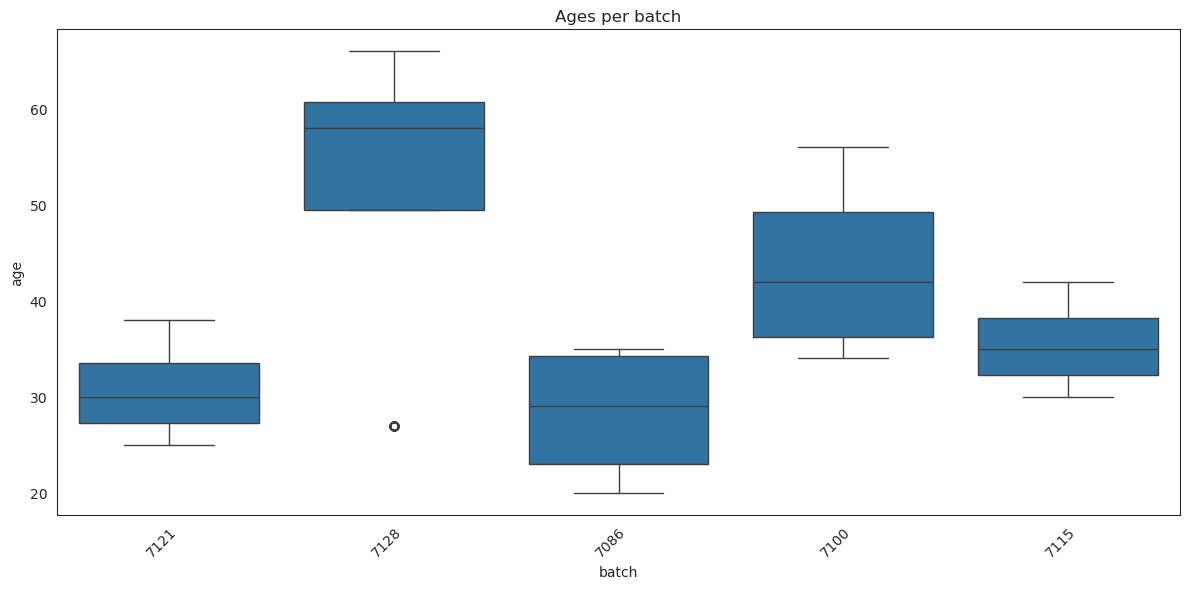

In [39]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, y="age", x="batch")
plt.title("Ages per batch")
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel("batch")
plt.ylabel("age")
plt.tight_layout()
plt.savefig(os.path.join(out, "ages_per_batch.png"))
plt.show()
plt.close()

Counts distributions

In [50]:
read_out_list = [
    "IL6_protein_expression_3,5hours",
    "IL6_protein_expression_20hours",
    "IL6",
]

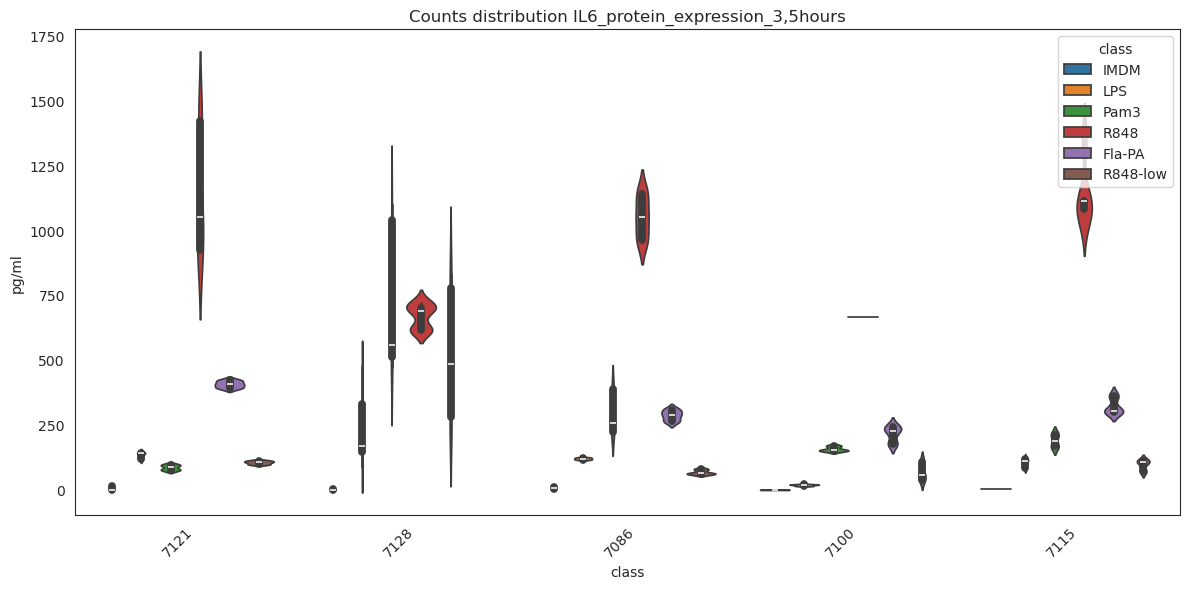

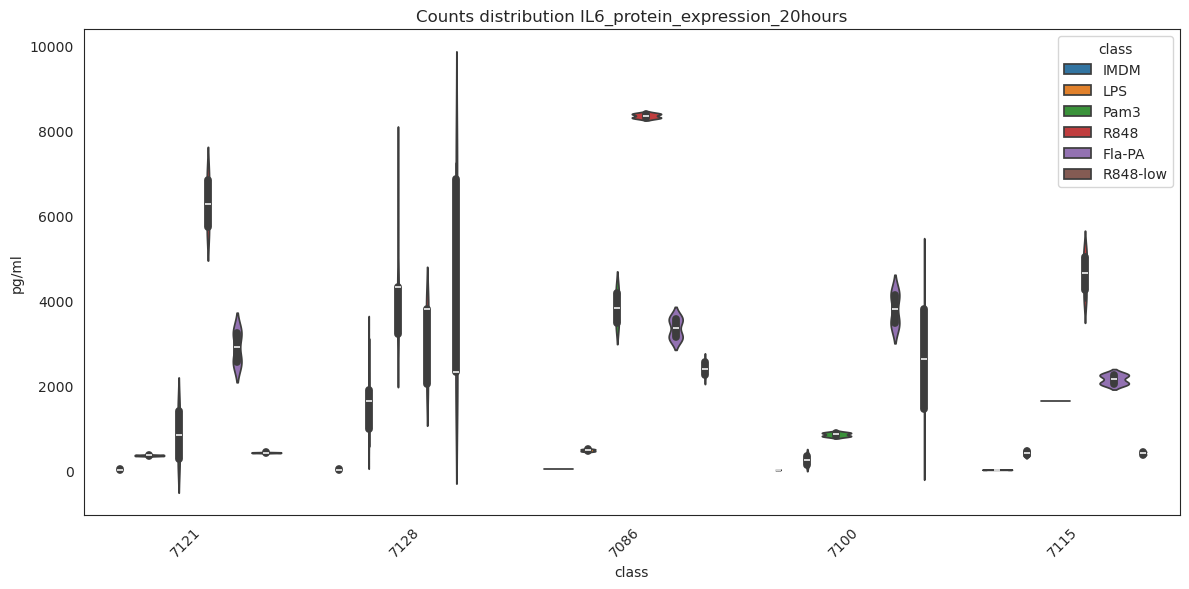

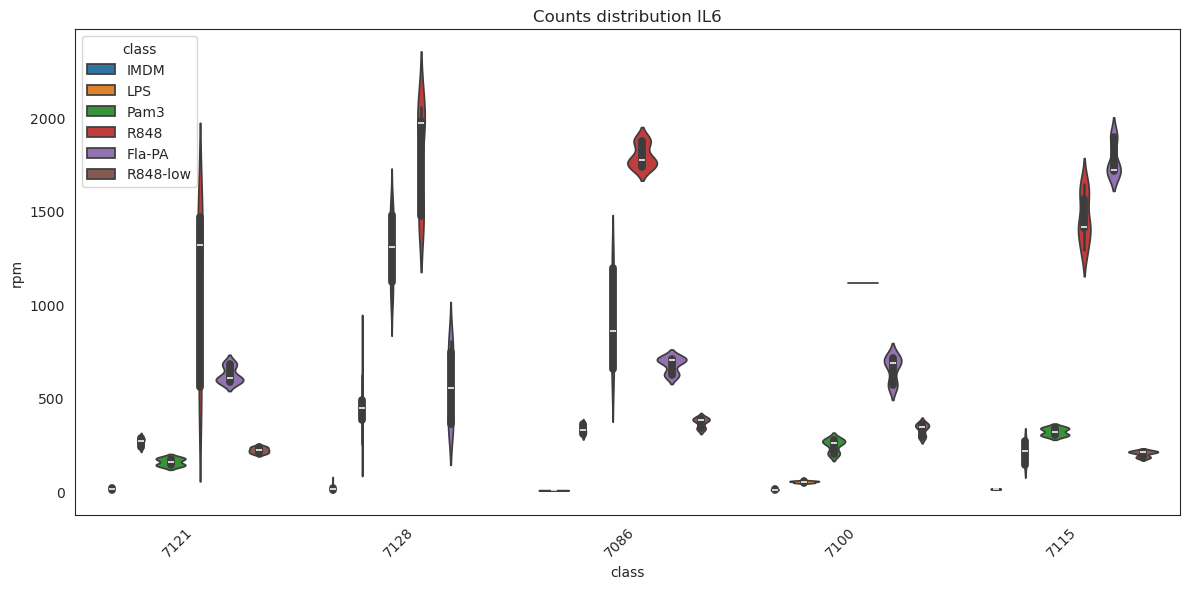

In [55]:
for read_out in read_out_list:
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=df, x="batch", hue="class", y=read_out)
    plt.title(f"Counts distribution {read_out}")
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    plt.xlabel("class")
    if "protein" in read_out:
        plt.ylabel("pg/ml")
    else:
        plt.ylabel("rpm")

    plt.tight_layout()
    plt.savefig(os.path.join(out, "counts_distribution_{name}_{read_out}.png"))
    plt.show()
    plt.close()

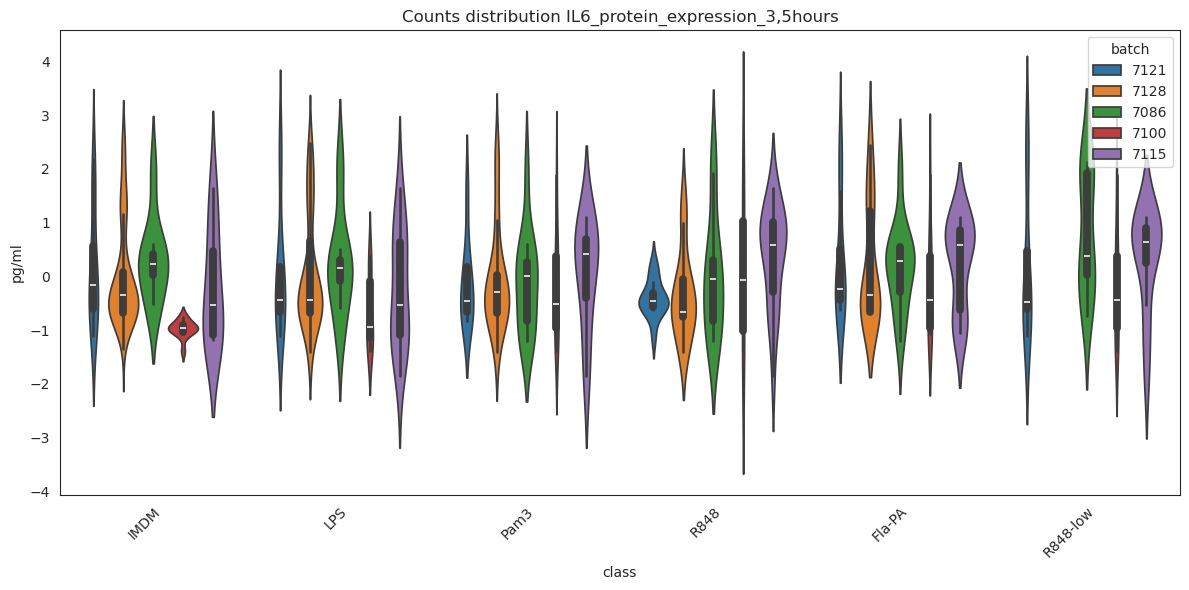

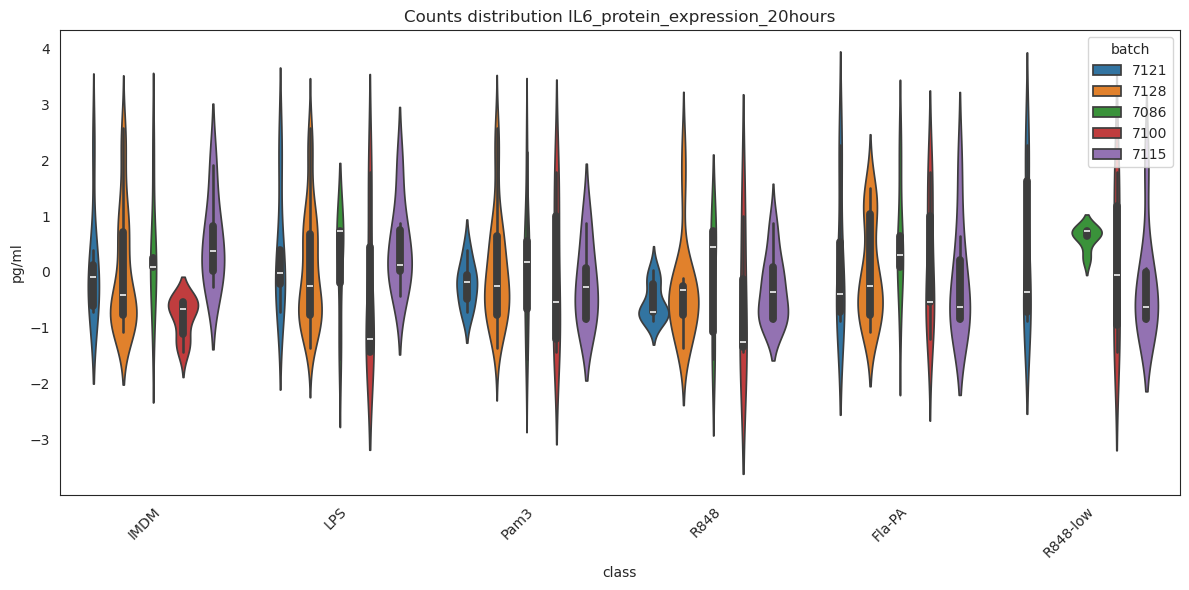

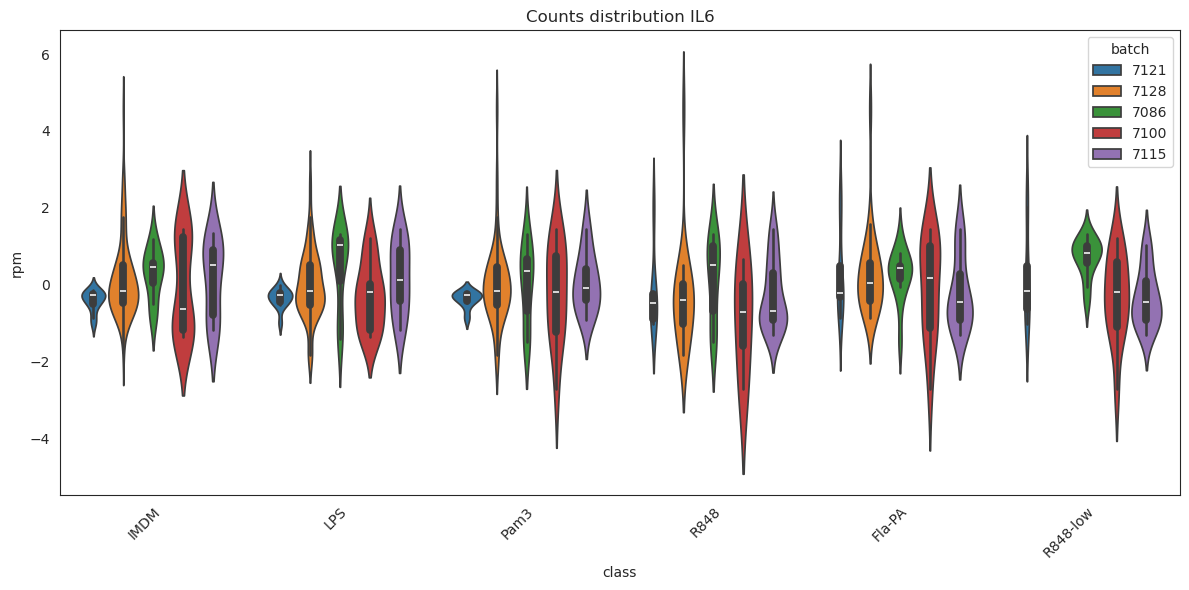

In [62]:
temp_df = df.copy()

transformed_df = df.groupby("class").apply(
    lambda group: group.select_dtypes(include="number").apply(
        stats.zscore,
        axis=0,
        ddof=1,
        nan_policy="omit",
    ),
    include_groups=False,
)
transformed_df.reset_index(drop=True, inplace=True)
temp_df[transformed_df.columns] = transformed_df

for read_out in read_out_list:
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=temp_df, x="class", hue="batch", y=read_out)
    plt.title(f"Counts distribution {read_out}")
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    plt.xlabel("class")
    if "protein" in read_out:
        plt.ylabel("pg/ml")
    else:
        plt.ylabel("rpm")

    plt.tight_layout()
    plt.savefig(os.path.join(out, "counts_distribution_{name}_{read_out}.png"))
    plt.show()
    plt.close()

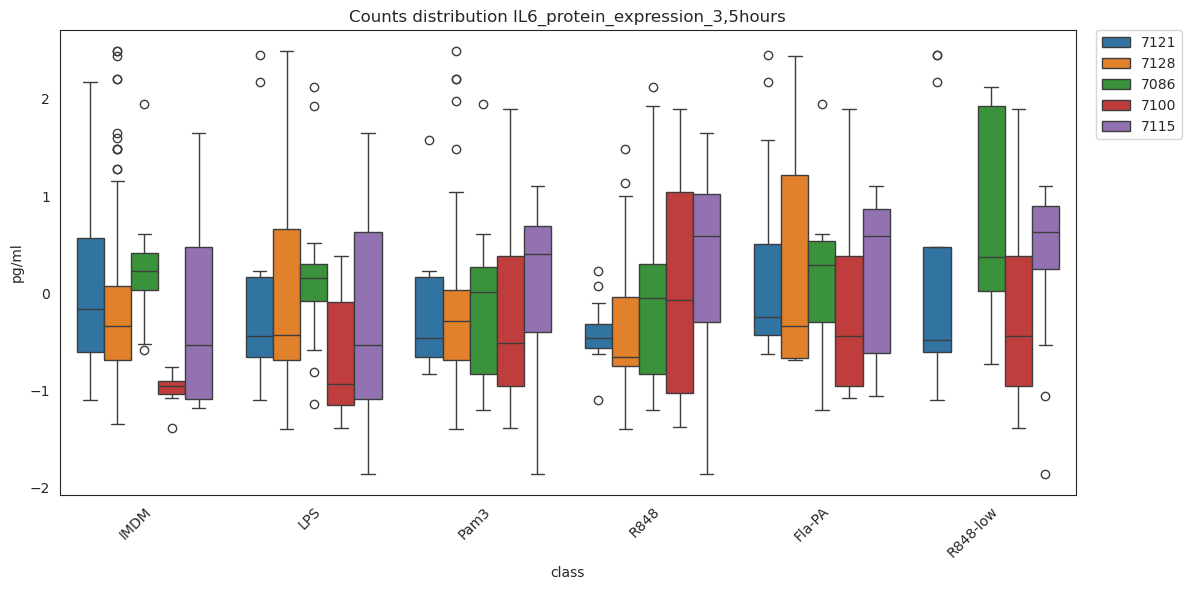

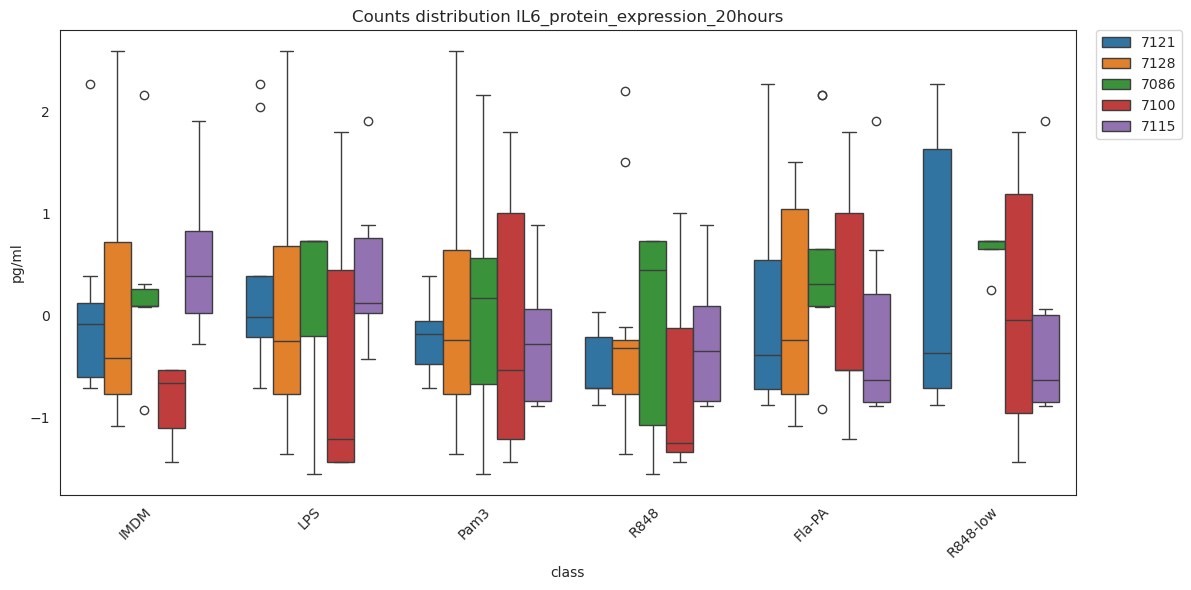

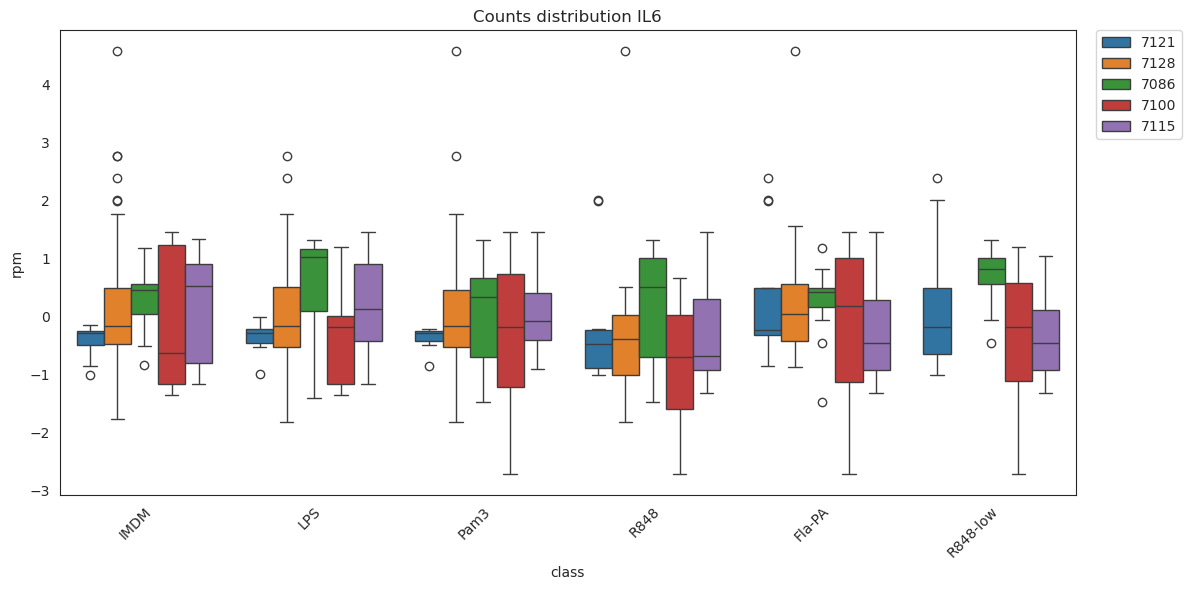

In [70]:
for read_out in read_out_list:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=temp_df, x="class", hue="batch", y=read_out)
    plt.title(f"Counts distribution {read_out}")
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    plt.xlabel("class")
    if "protein" in read_out:
        plt.ylabel("pg/ml")
    else:
        plt.ylabel("rpm")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.tight_layout()
    plt.savefig(os.path.join(out, "counts_distribution_{name}_{read_out}.png"))
    plt.show()
    plt.close()

In [71]:
del temp_df

ANOVA

In [43]:
"""
Make one way ANOVA
"""

f_val_list = []
p_val_list = []
names_list = []

for name, group in df.groupby("class"):
    samples = [group[1] for group in group.groupby("batch")["IL6"]]
    if len(samples) > 1:
        f_val, p_val = stats.f_oneway(*samples)
        print(f"Class: {name}, F value: {f_val:.2f}, p value: {p_val}")
        f_val_list.append(f_val)
        p_val_list.append(p_val)
        names_list.append(name)

anova_stats = pd.DataFrame(
    {
        "class": names_list,
        "f_value": f_val_list,
        "p_value": p_val_list,
    }
)
anova_stats
# anova_stats["class"]=names_list
# anova_stats["f_value"]=f_val_list
# anova_stats["p_value"]=p_val_list

Class: Fla-PA, F value: 219.01, p value: 1.0801233698799337e-37
Class: IMDM, F value: 2.83, p value: 0.02761915472136287
Class: LPS, F value: 40.17, p value: 1.7153442588128868e-21
Class: Pam3, F value: 187.04, p value: 1.891847851619323e-39
Class: R848, F value: 21.89, p value: 2.337282159928971e-11
Class: R848-low, F value: 174.29, p value: 1.96606106832429e-24


,class,f_value,p_value
0,Fla-PA,219.01,1.08e-37
1,IMDM,2.83,2.76e-02
2,LPS,40.17,1.72e-21
3,Pam3,187.04,1.89e-39
4,R848,21.89,2.34e-11
5,R848-low,174.29,1.97e-24


In [44]:
f_oneway(*[s for idx, s in df.groupby("age").IL6]), f_oneway(
    *[s for idx, s in df.groupby("batch").IL6]
)

(F_onewayResult(statistic=1.4600539329542073, pvalue=0.10436306605474603),
 F_onewayResult(statistic=9.282223006227982, pvalue=3.004493372019485e-07))

Pearson correlations

In [123]:
mean_age = df.groupby("batch")["age"].mean()
mean_age = mean_age.to_frame(name="age")
mean_age

,age
batch,
7086,28.25
7100,43.50
7115,35.50
7121,30.75
7128,52.25


In [ ]:
df[df["batch"] == mean_age.index]

In [ ]:
df['age'][] = mean_age['age']

In [136]:
df["mean_age"] = df.groupby("batch")["age"].transform("mean")
df = df.drop(columns="age")

In [137]:
df

,sex,"IL6_protein_expression_3,5hours",IL6_protein_expression_20hours,IL6,class,batch,experiment,mean_age
0,0.0,1.0,8.0,21.0,IMDM,7121,MD214,30.75
1,0.0,0.0,19.0,14.0,IMDM,7121,MD214,30.75
2,0.0,13.0,NaN,10.0,IMDM,7121,MD214,30.75
3,0.0,140.0,358.0,271.0,LPS,7121,MD214,30.75
4,0.0,118.0,338.0,238.0,LPS,7121,MD214,30.75
...,...,...,...,...,...,...,...,...
515,0.5,1110.0,4010.0,1565.0,R848,7115,MD218,35.50
516,0.5,1030.0,4310.0,1642.0,R848,7115,MD218,35.50
517,0.5,112.0,367.0,213.0,R848-low,7115,MD224,35.50
518,0.5,106.0,433.0,183.0,R848-low,7115,MD224,35.50


In [138]:
corr = df.corr(method="pearson", min_periods=1, numeric_only=True)
corr.style.background_gradient(cmap="coolwarm", axis=None)

,sex,"IL6_protein_expression_3,5hours",IL6_protein_expression_20hours,IL6,mean_age
sex,1.000000,-0.011968,-0.127756,0.007205,0.973442
"IL6_protein_expression_3,5hours",-0.011968,1.000000,0.849241,0.802245,-0.054758
IL6_protein_expression_20hours,-0.127756,0.849241,1.000000,0.752720,-0.140694
IL6,0.007205,0.802245,0.752720,1.000000,-0.047791
mean_age,0.973442,-0.054758,-0.140694,-0.047791,1.000000


In [139]:
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(
    corr.style.background_gradient(cmap="coolwarm", axis=None, vmin=-1, vmax=1)
    .highlight_null(color="#f1f1f1")  # Color NaNs grey
    .format(precision=2)
)

,sex,"IL6_protein_expression_3,5hours",IL6_protein_expression_20hours,IL6,mean_age
sex,nan,nan,nan,nan,nan
"IL6_protein_expression_3,5hours",-0.01,nan,nan,nan,nan
IL6_protein_expression_20hours,-0.13,0.85,nan,nan,nan
IL6,0.01,0.80,0.75,nan,nan
mean_age,0.97,-0.05,-0.14,-0.05,nan


In [143]:
list(df.columns)

['sex',
 'IL6_protein_expression_3,5hours',
 'IL6_protein_expression_20hours',
 'IL6',
 'class',
 'batch',
 'experiment',
 'mean_age']

In [144]:
# read_out_coupled = list(zip(read_out_list,read_out_list))
to_compare = [
    "sex",
    "IL6_protein_expression_3,5hours",
    "IL6_protein_expression_20hours",
    "IL6",
    "mean_age",
]
read_out_coupled = [(i, j) for i in read_out_list for j in to_compare]

In [145]:
list(read_out_coupled)

[('IL6_protein_expression_3,5hours', 'sex'),
 ('IL6_protein_expression_3,5hours', 'IL6_protein_expression_3,5hours'),
 ('IL6_protein_expression_3,5hours', 'IL6_protein_expression_20hours'),
 ('IL6_protein_expression_3,5hours', 'IL6'),
 ('IL6_protein_expression_3,5hours', 'mean_age'),
 ('IL6_protein_expression_20hours', 'sex'),
 ('IL6_protein_expression_20hours', 'IL6_protein_expression_3,5hours'),
 ('IL6_protein_expression_20hours', 'IL6_protein_expression_20hours'),
 ('IL6_protein_expression_20hours', 'IL6'),
 ('IL6_protein_expression_20hours', 'mean_age'),
 ('IL6', 'sex'),
 ('IL6', 'IL6_protein_expression_3,5hours'),
 ('IL6', 'IL6_protein_expression_20hours'),
 ('IL6', 'IL6'),
 ('IL6', 'mean_age')]

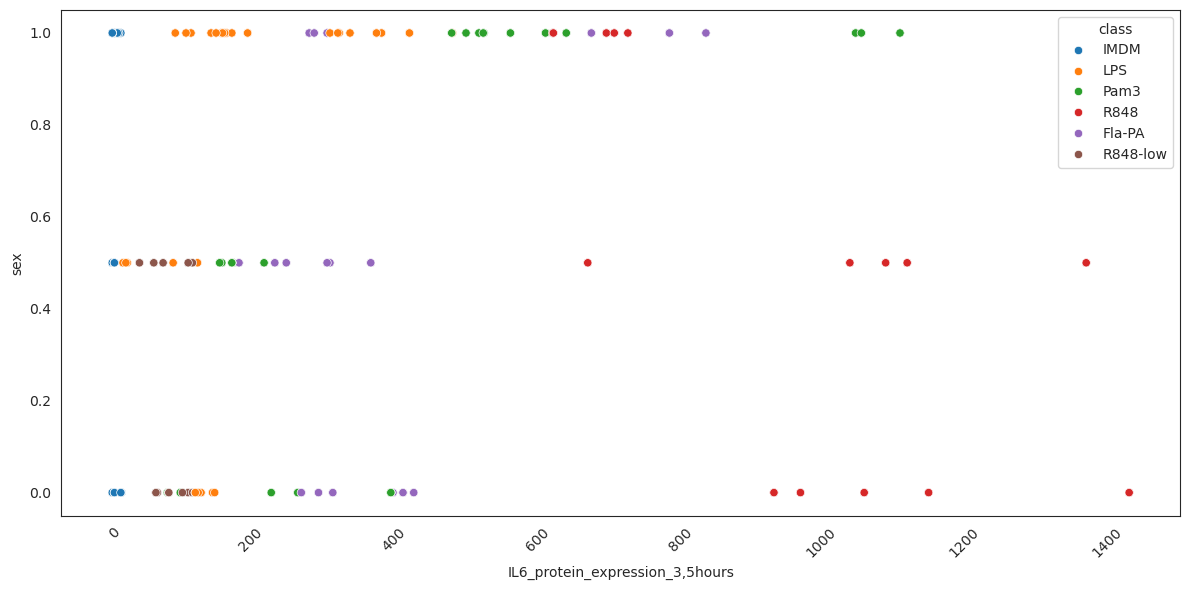

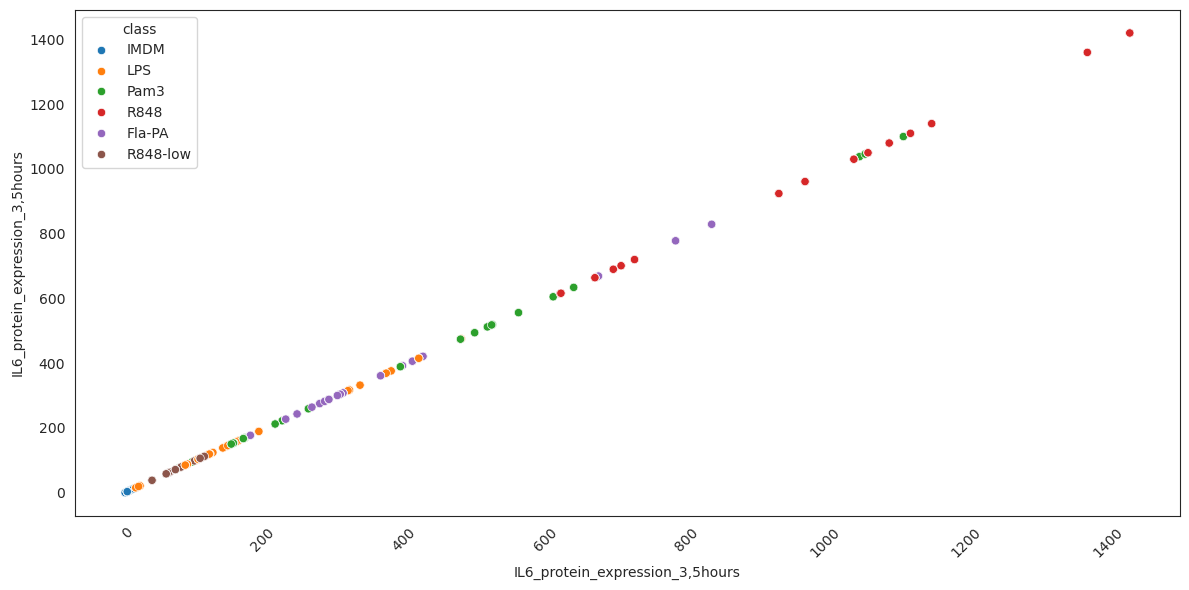

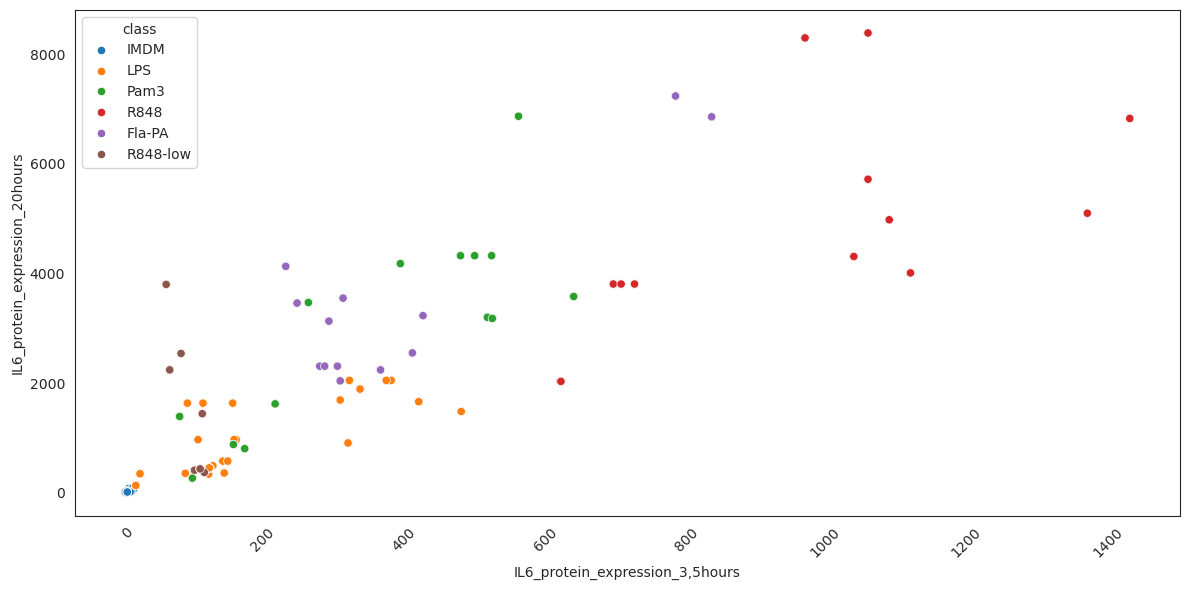

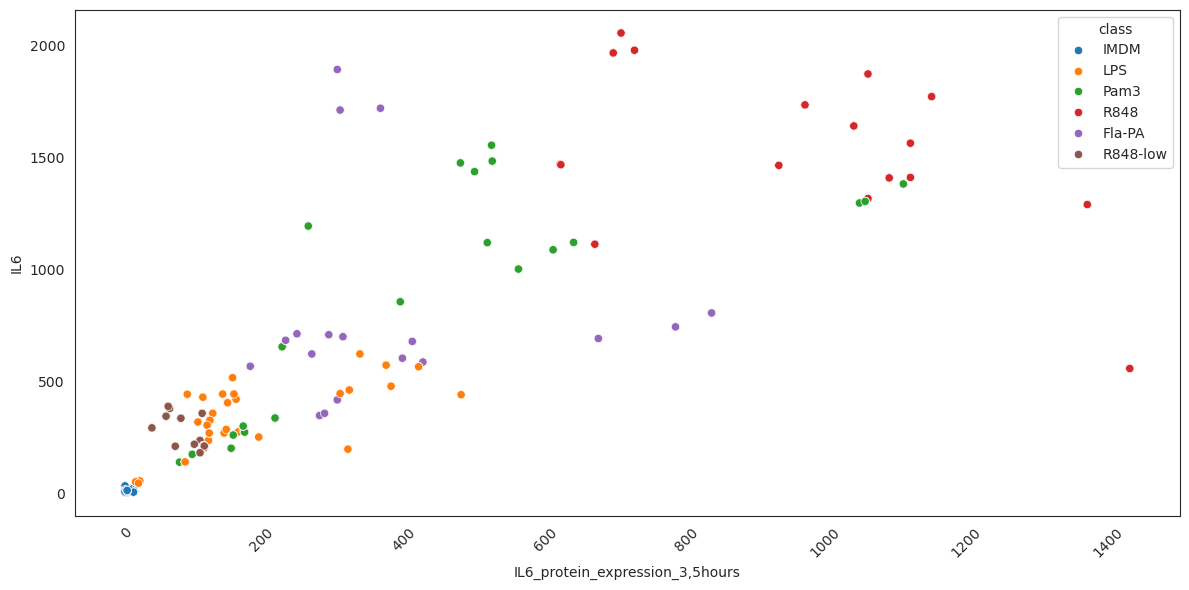

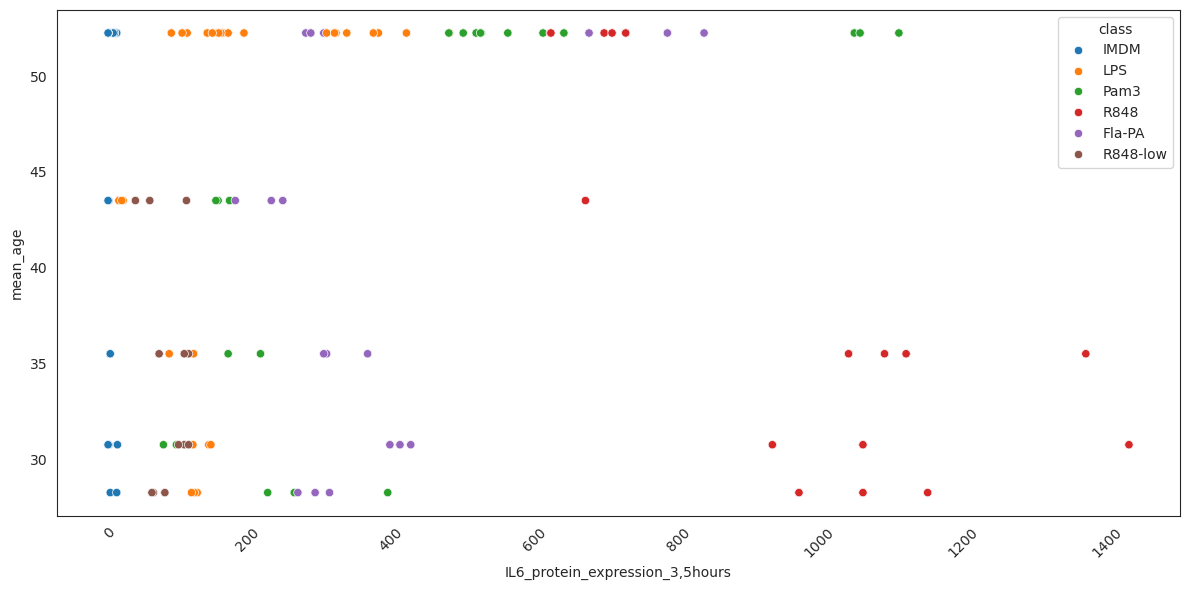

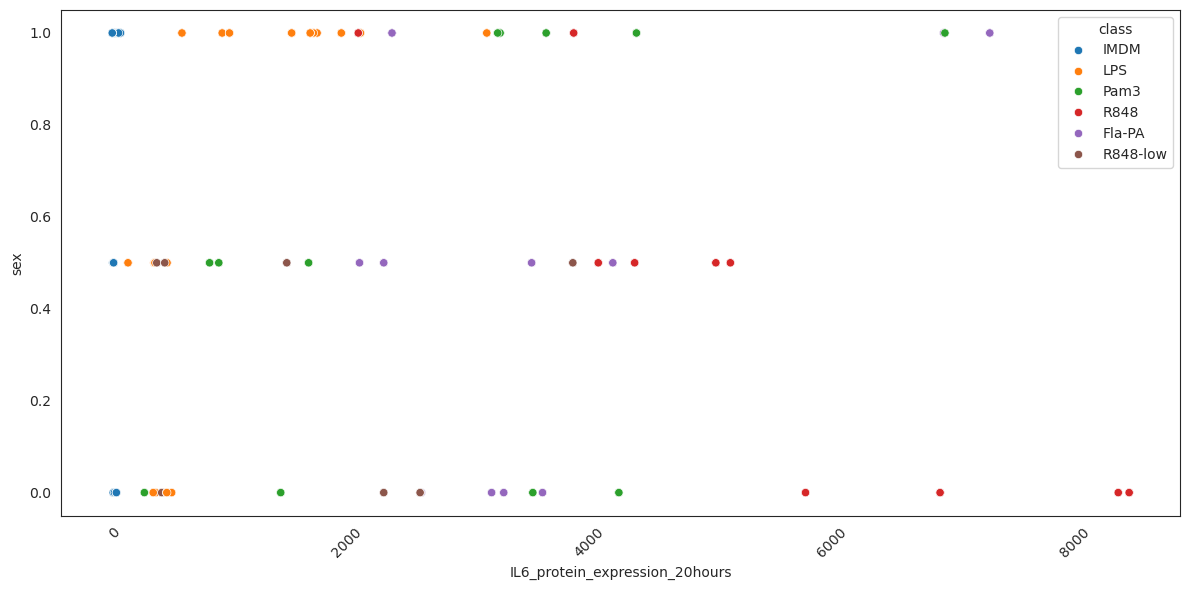

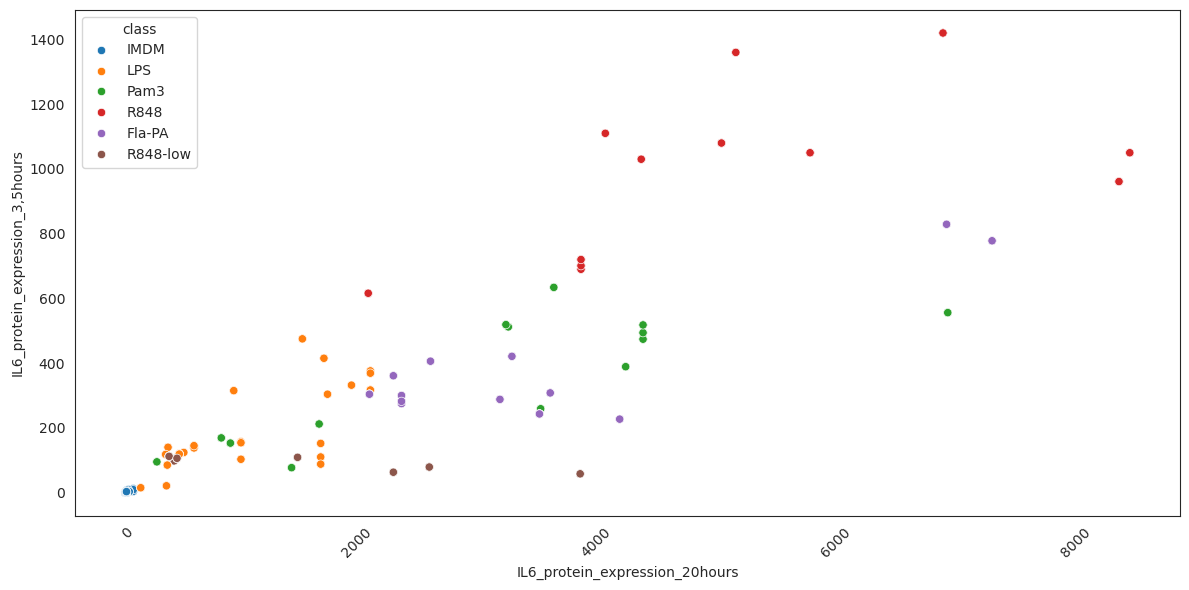

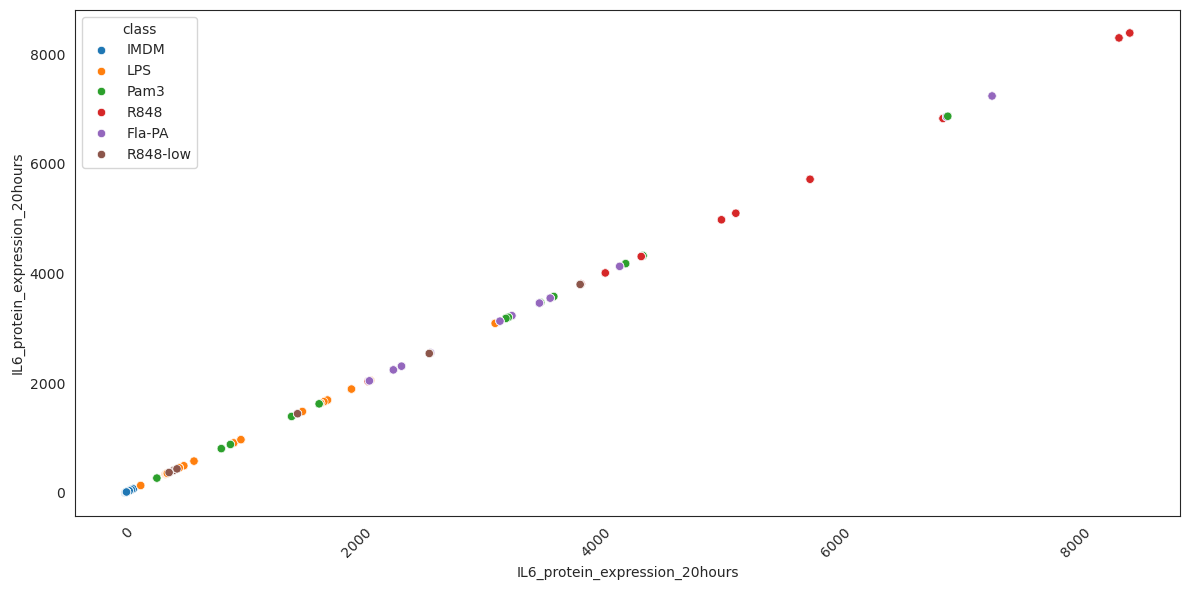

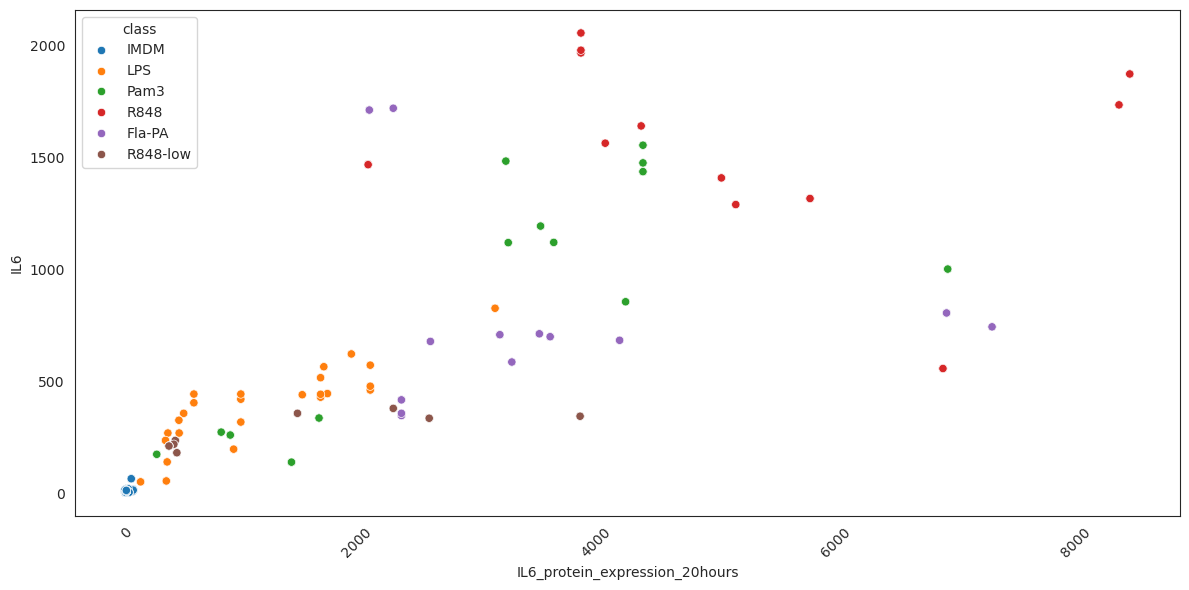

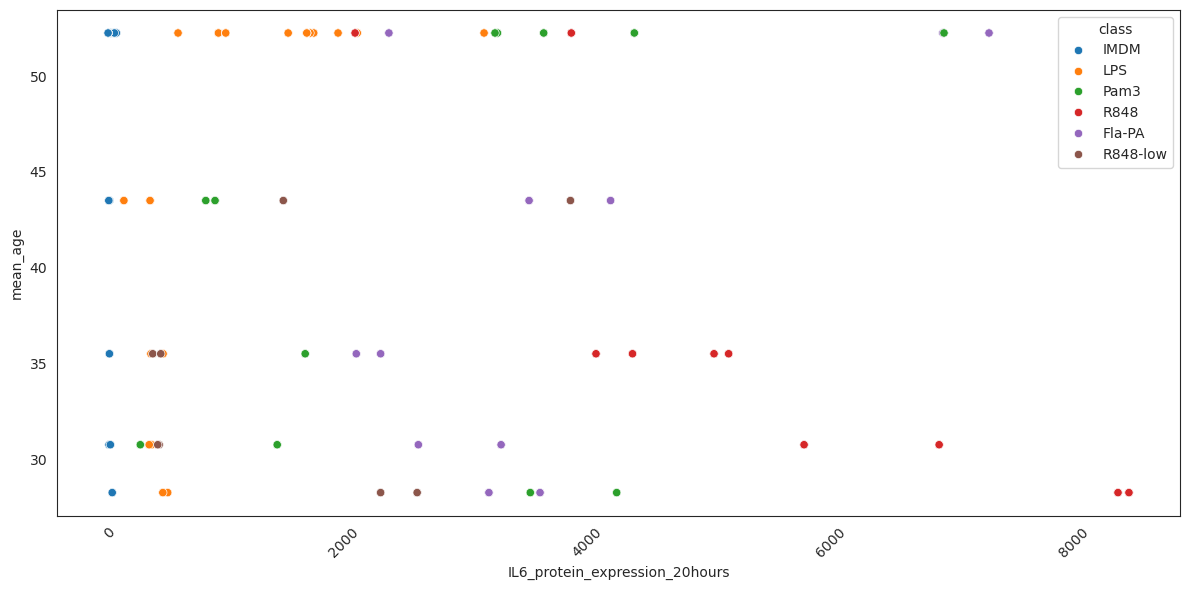

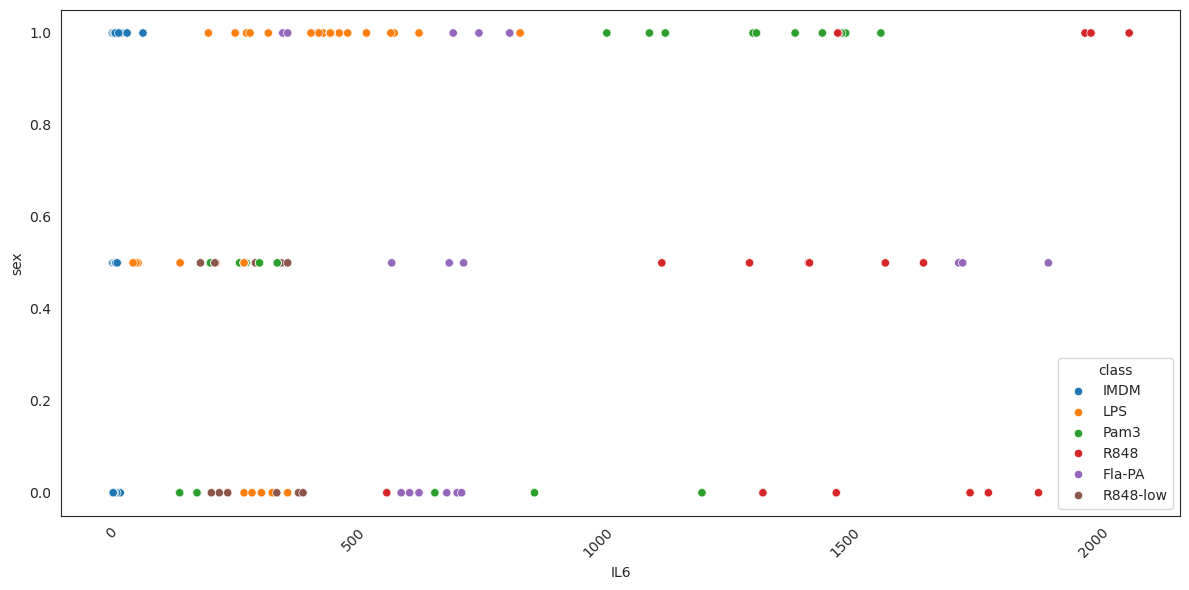

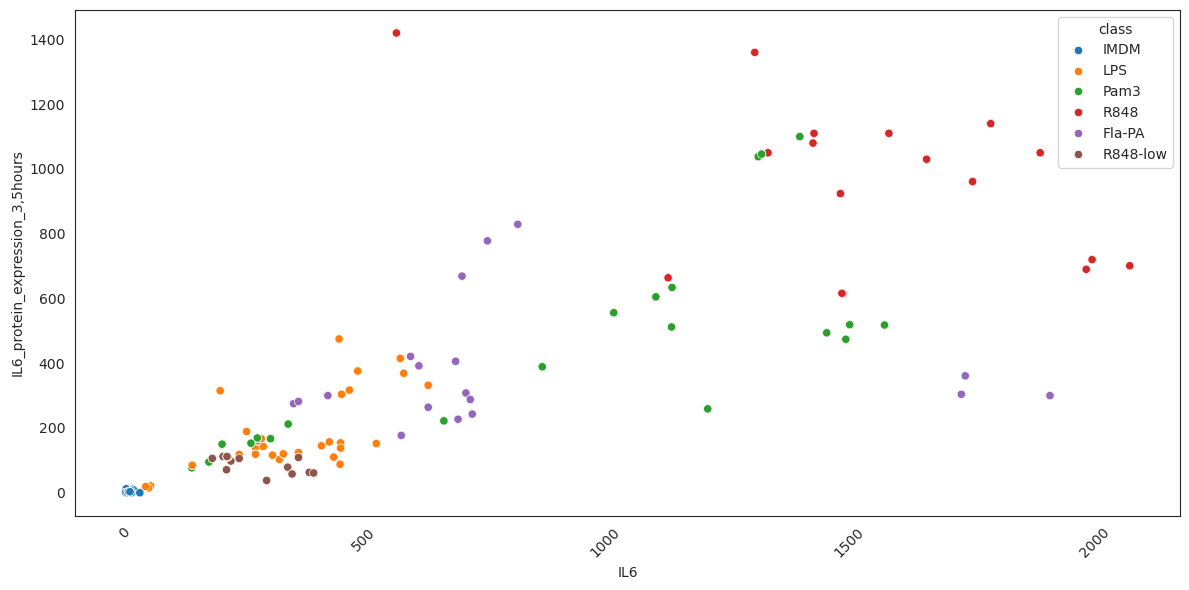

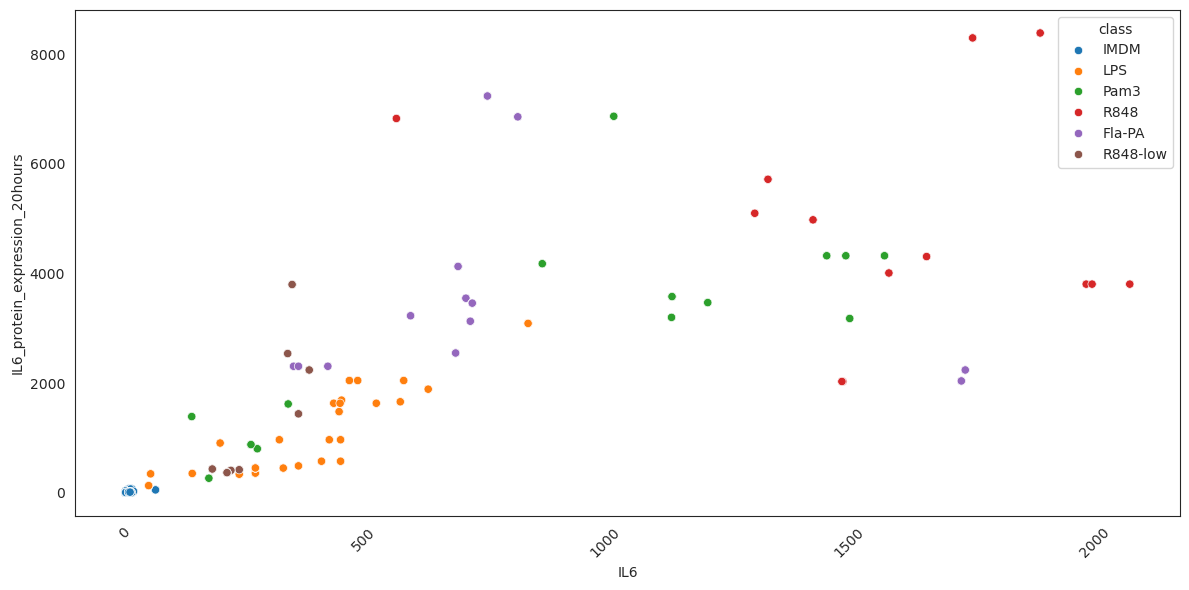

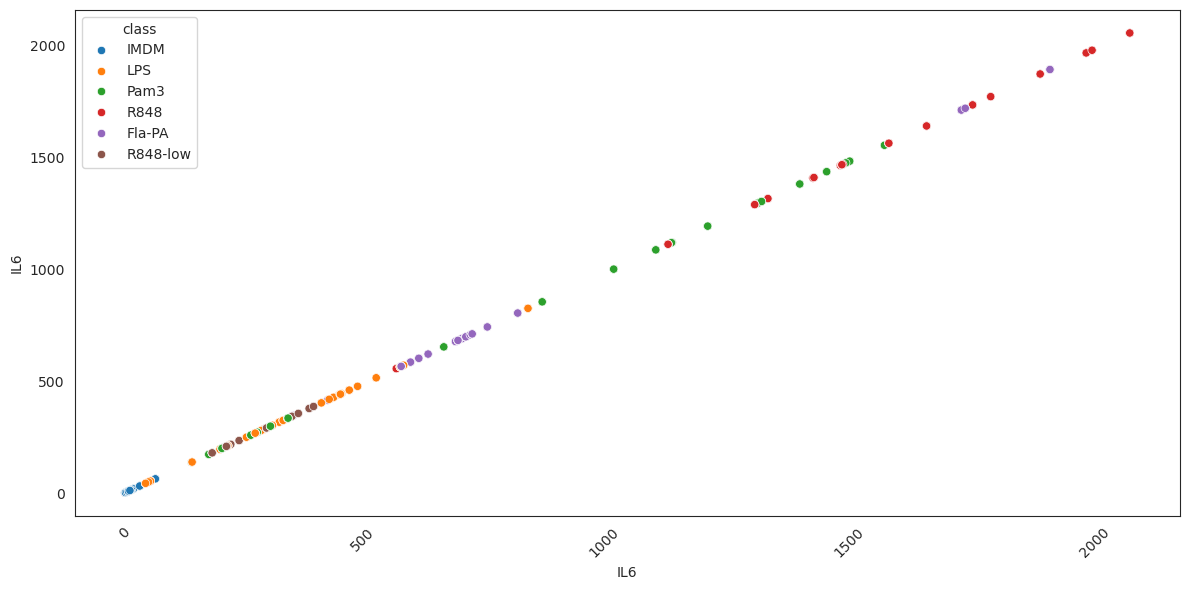

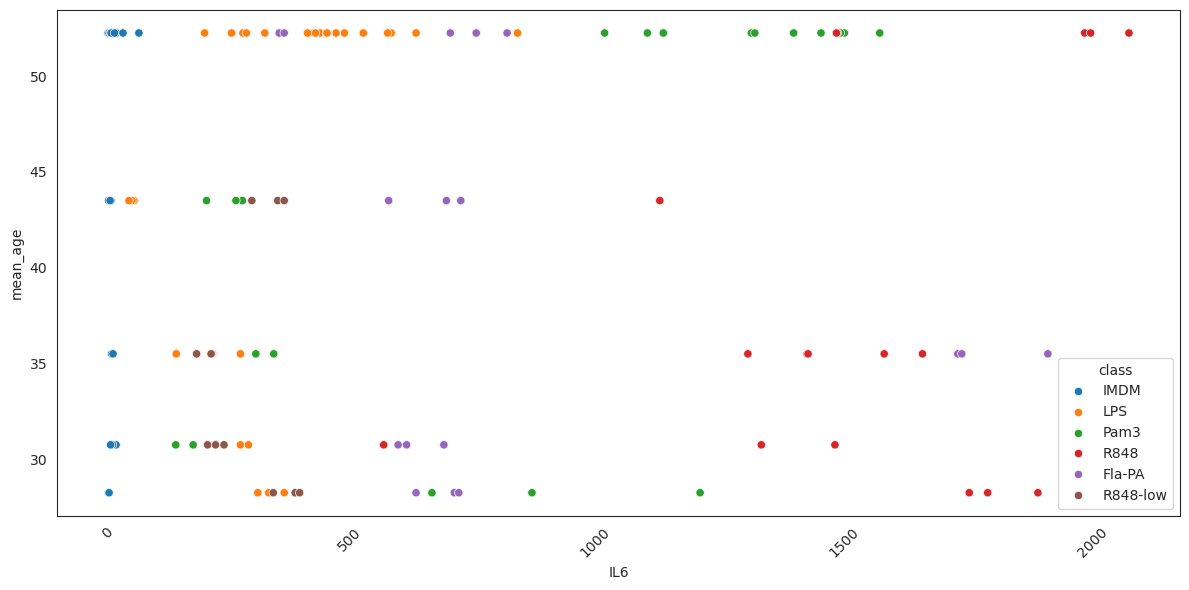

In [147]:
for combination in read_out_coupled:

    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x=combination[0], hue="class", y=combination[1])
    # plt.title(f"Counts distribution {read_out}")
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    # plt.xlabel("class")
    # if 'protein' in read_out:
    #   plt.ylabel("pg/ml")
    # else:
    #   plt.ylabel("rpm")
    # plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.tight_layout()
    # plt.savefig(os.path.join(out, "counts_distribution_{name}_{read_out}.png"))
    plt.show()
    plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1200x600 with 0 Axes>

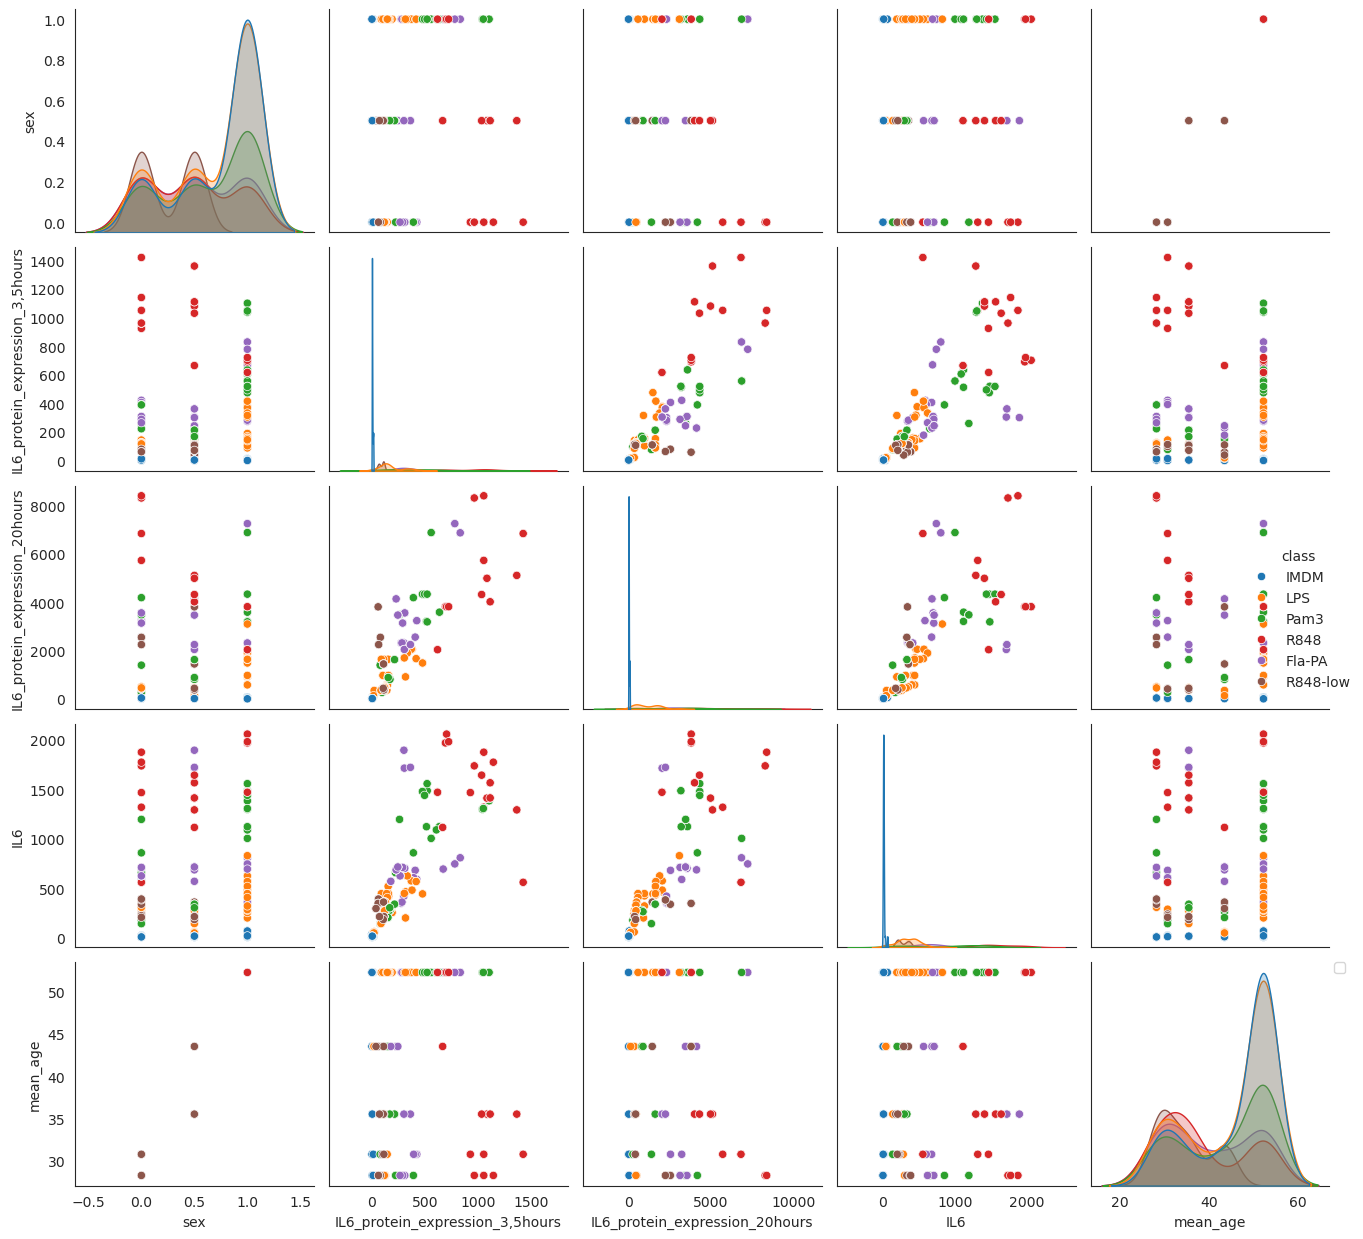

In [141]:
# for combination in read_out_coupled:

plt.figure(figsize=(12, 6))
sns.pairplot(data=df, hue="class")
# plt.title(f"Counts distribution {read_out}")
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
# plt.xlabel("class")
# if 'protein' in read_out:
#   plt.ylabel("pg/ml")
# else:
#   plt.ylabel("rpm")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
# plt.savefig(os.path.join(out, "counts_distribution_{name}_{read_out}.png"))
plt.show()
plt.close()

In [94]:
('IL6_protein_expression_3,5hours', 'IL6') == ('IL6', 'IL6_protein_expression_3,5hours')

for i 

False